# Mapping outcomes

## Proportions of stroke types: Analysis of SAMueL data

## Import packages

In [19]:
# import contextily as ctx
import geopandas
import numpy as np
import pandas as pd
import os

# For plotting:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.geo  # to make catchment area geometry

pd.set_option('display.max_rows', 150)

In [20]:
dir_output = 'output'
limit_to_england = False

## Load data

### Load shape file

In [21]:
lsoa_gdf = stroke_maps.load_data.lsoa_geography()
lsoa_gdf = lsoa_gdf.to_crs('EPSG:27700')

lsoa_gdf.head(3)

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.09706,51.51810,157794.481079,1685.391778,b12173a3-5423-4672-a5eb-f152d2345f96,"POLYGON ((532282.642 181906.500, 532248.262 18..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.09197,51.51868,164882.427628,1804.828196,90274dc4-f785-4afb-95cd-7cc1fc9a2cad,"POLYGON ((532746.826 181786.896, 532248.262 18..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.09523,51.52176,42219.805717,909.223277,7e89d0ba-f186-45fb-961c-8f5ffcd03808,"POLYGON ((532293.080 182068.426, 532419.605 18..."


In [22]:
# Load country outline
if limit_to_england:
    outline = stroke_maps.load_data.england_outline()
else:
    outline = stroke_maps.load_data.englandwales_outline()

In [23]:
outline

,country,OBJECTID,ctry11cd,ctry11cdo,ctry11nm,ctry11nmw,GlobalID,geometry
0,0,1,E92000001,921,England,Lloegr,27bbf7ca-99bd-4fe8-87a1-d498d48e3084,"MULTIPOLYGON (((83994.599 5397.099, 84001.300 ..."


### Load hospital info

Load in the stroke unit coordinates and merge in the services information:

In [24]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

df_units.head(3).T

postcode,SY231ER,CB20QQ,L97AL
stroke_team,Bronglais Hospital (Aberystwyth),"Addenbrooke's Hospital, Cambridge","University Hospital Aintree, Liverpool"
short_code,AB,AD,AI
ssnap_name,Bronglais Hospital,Addenbrooke's Hospital,University Hospital Aintree
use_ivt,1,1,1
use_mt,0,1,1
use_msu,0,1,1
transfer_unit_postcode,nearest,nearest,nearest
lsoa,Ceredigion 002A,Cambridge 013D,Liverpool 005A
lsoa_code,W01000512,E01017995,E01006654
region,Hywel Dda University Health Board,NHS Cambridgeshire and Peterborough ICB - 06H,NHS Cheshire and Merseyside ICB - 99A


In [25]:
hospitals_gdf = stroke_maps.load_data.stroke_unit_coordinates()
hospitals_gdf = pd.merge(
    hospitals_gdf, df_units[['use_ivt', 'use_mt']],
    left_index=True, right_index=True, how='right'
)

In [26]:
hospitals_gdf.head(3)

,BNG_E,BNG_N,Latitude,Longitude,geometry,use_ivt,use_mt
postcode,,,,,,,
SY231ER,259208,281805,52.416068,-4.071578,POINT (259208.000 281805.000),1,0
CB20QQ,546375,254988,52.173741,0.139114,POINT (546375.000 254988.000),1,1
L97AL,338020,397205,53.467918,-2.935131,POINT (338020.000 397205.000),1,1


### Load LSOA model output data

In [27]:
lsoa_data = pd.read_csv(os.path.join(dir_output, 'cohort_outcomes_weighted.csv'))
lsoa_data.head(3).T

,0,1,2
lsoa,Adur 001A,Adur 001B,Adur 001C
closest_ivt_time,17.6,18.7,17.6
closest_ivt_unit,BN25BE,BN25BE,BN112DH
closest_mt_time,17.6,18.7,19.8
closest_mt_unit,BN25BE,BN25BE,BN25BE
transfer_mt_time,0.0,0.0,31.6
transfer_mt_unit,BN25BE,BN25BE,BN25BE
mt_transfer_required,False,False,True
ivt_drip_ship,107.6,108.7,107.6
mt_drip_ship,167.6,168.7,259.2


In [28]:
# Merge with shape file

lsoa_data_gdf = lsoa_gdf.merge(lsoa_data, left_on='LSOA11NM', right_on='lsoa', how='right')
lsoa_data_gdf.head()

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,...,mothership_weighted_mrs_shift,mothership_weighted_added_mrs_less_equal_2,drip_ship_weighted_treated_added_utility,drip_ship_weighted_treated_mrs_less_equal_2,drip_ship_weighted_treated_mrs_shift,drip_ship_weighted_treated_added_mrs_less_equal_2,mothership_weighted_treated_added_utility,mothership_weighted_treated_mrs_less_equal_2,mothership_weighted_treated_mrs_shift,mothership_weighted_treated_added_mrs_less_equal_2
0,30557.0,E01031349,Adur 001A,Adur 001A,524915.0,105607.0,-0.22737,50.83651,3.641032e+05,3054.751704,...,-0.17815,0.03626,0.13633,0.56689,-0.71592,0.14571,0.13633,0.56689,-0.71592,0.14571
1,30558.0,E01031350,Adur 001B,Adur 001B,524825.0,106265.0,-0.22842,50.84244,2.921732e+05,2977.102897,...,-0.17740,0.03611,0.13579,0.56630,-0.71290,0.14512,0.13579,0.56630,-0.71290,0.14512
2,30559.0,E01031351,Adur 001C,Adur 001C,523053.0,108004.0,-0.25300,50.85845,5.281768e+06,11671.349143,...,-0.17665,0.03597,0.11106,0.53979,-0.58086,0.11861,0.13525,0.56571,-0.70988,0.14453
3,30560.0,E01031352,Adur 001D,Adur 001D,524141.0,106299.0,-0.23812,50.84290,2.452292e+05,2134.908586,...,-0.17665,0.03597,0.11106,0.53979,-0.58086,0.11861,0.13525,0.56571,-0.70988,0.14453
4,30578.0,E01031370,Adur 001E,Adur 001E,523561.0,105916.0,-0.24649,50.83958,2.402445e+05,2447.096939,...,-0.17665,0.03597,0.11159,0.54036,-0.58379,0.11918,0.13525,0.56571,-0.70988,0.14453


## Calculate difference between Mothership and Drip and Ship

In [29]:
cohort_names = ['nlvo_ivt', 'lvo_mix', 'weighted_treated']

outcome_names = ['added_utility', 'added_mrs_less_equal_2', 'mrs_shift']

In [30]:
cols_diff = [f'{c}_{o}_mothership_minus_dripship' for c in cohort_names for o in outcome_names]
cols_moth = [f'mothership_{c}_{o}' for c in cohort_names for o in outcome_names]
cols_drip = [f'drip_ship_{c}_{o}' for c in cohort_names for o in outcome_names]

lsoa_data_gdf[cols_diff] = lsoa_data_gdf[cols_moth].values - lsoa_data_gdf[cols_drip].values

## Basic plot

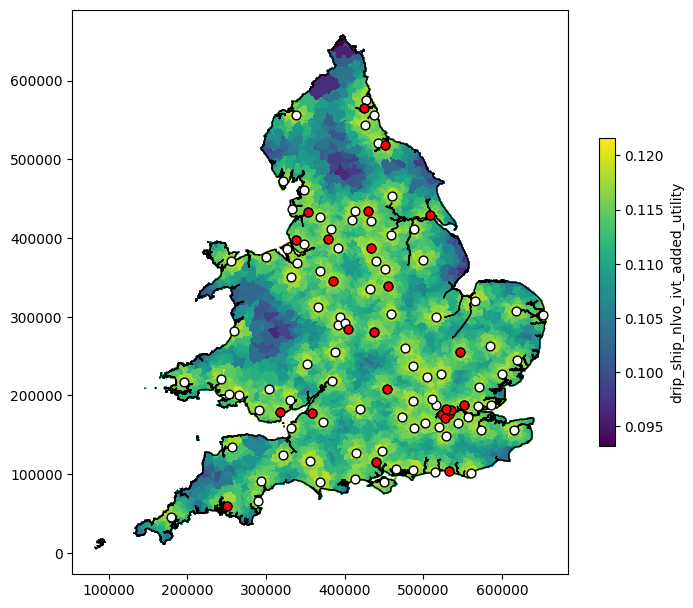

In [31]:
col = 'drip_ship_nlvo_ivt_added_utility'

# Figure setup:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot data
lsoa_data_gdf.plot(
    ax=ax,             # Set which axes to use for plot
    column=col,        # Column to apply colour
    antialiased=False, # Avoids artefact boundry lines
    edgecolor='face',  # Make LSOA boundary same colour as area
    # Adjust size of colourmap key, and add label
    legend_kwds={'shrink':0.5, 'label':col},
    legend=True,       # Set to display legend
)

# Add country border
outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)

# Add hospitals
mask = hospitals_gdf['use_ivt'] == 1
hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
mask = hospitals_gdf['use_mt'] == 1
hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')

plt.show()

## Plots

### Define functions

These functions find shared colour limits across multiple columns of data:

In [33]:
def find_vlims_scenarios(lsoa_data_gdf, data_field, cohorts):
    scenarios = ['drip_ship', 'mothership']
    # Colour limits for separate scenarios:
    cols = [f'{s}_{c}_{data_field}' for s in scenarios for c in cohorts]
    # Find maximum of data
    vmin = np.min([lsoa_data_gdf[col].min() for col in cols])
    vmax = np.max([lsoa_data_gdf[col].max() for col in cols])
    return vmin, vmax

def find_vlims_diff(lsoa_data_gdf, data_field, cohorts):
    # Colour limits for difference maps:
    cols = [f'{c}_{data_field}_mothership_minus_dripship' for c in cohorts]
    # Find absolute maximum of data extent
    vmax = np.max((np.abs([lsoa_data_gdf[col].min() for col in cols]),
                   np.abs([lsoa_data_gdf[col].max() for col in cols])))
    vmin = -vmax
    return vmin, vmax

This function plots the maps:

In [43]:
def plot_data(axs, cax, cax_diff, axs_cols, axs_params, colour_params):
    for row in range(len(axs_cols)):
        for col in range(len(axs_cols[row])):
            # Axis to plot on:
            ax = axs[row, col]
            # Data information:
            col_data = axs_cols[row][col]
            # Colour information:
            colour_params_type = axs_params[row][col]
            params = colour_params[colour_params_type]
            cbar_ax = cax if colour_params_type == 'shared' else cax_diff
            
            # Plot data
            lsoa_data_gdf.plot(
                ax=ax,
                column=col_data,      # Column to apply colour
                antialiased=False,    # Avoids artefact boundry lines
                edgecolor='face',     # Make LSOA boundry same colour as area
                vmin=params['vmin'],  # Manual scale min (remove to make automatic)
                vmax=params['vmax'],  # Manual scale max (remove to make automatic)
                cmap=params['cmap'],  # Colour map to use
                # Adjust size of colourmap key, and add label
                legend_kwds={'shrink':0.5, 'label':params['cbar_label']},
                legend=True,          # Set to display legend
                cax=cbar_ax
            )

These functions set up the figure and standard formatting across all axes:

In [44]:
def set_up_fig_nine():
    fig = plt.figure(figsize=(14, 18))

    # Set up GridSpec so that each map subplot takes up two gs subplots
    # in height. This lets the shared colourbar sit midway up two
    # subplots instead of being offset or twice the height of the other.
    gs = GridSpec(7, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.0, hspace=0.0)
    axs = np.array([
        [plt.subplot(gs[0:2, 0]), plt.subplot(gs[0:2, 1]), plt.subplot(gs[0:2, 2])],
        [plt.subplot(gs[2:4, 0]), plt.subplot(gs[2:4, 1]), plt.subplot(gs[2:4, 2])],
        [plt.subplot(gs[4:6, 0]), plt.subplot(gs[4:6, 1]), plt.subplot(gs[4:6, 2])],
    ])
    cax = plt.subplot(gs[1:3, -1])
    cax_diff = plt.subplot(gs[4:6, -1])
    return fig, axs, cax, cax_diff

def set_up_axis_and_extras(ax, outline, hospitals_gdf):
    # Add country border
    outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
    
    # Add hospitals
    mask = hospitals_gdf['use_ivt'] == 1
    hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
    mask = hospitals_gdf['use_mt'] == 1
    hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')

    # ax.set_axis_off() # Turn of axis line and numbers
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)

    # Tighten map around mainland England and Wales
    ax.set_xlim(120000)
    return ax

This function makes the plots for nine maps together:

In [45]:
def plot_nine(
        lsoa_data_gdf,
        axs_cols,
        axs_params,
        colour_params,
        hospitals_gdf,
        outline,
        col_titles=[],
        row_titles=[],
        savename=''
    ):
    fig, axs, cax, cax_diff = set_up_fig_nine()

    plot_data(axs, cax, cax_diff, axs_cols, axs_params, colour_params)

    for ax in axs.flatten():
        ax = set_up_axis_and_extras(ax, outline, hospitals_gdf)

    for i, row_title in enumerate(row_titles):
        axs[i, 0].set_ylabel(row_title, rotation=0, fontsize=14, labelpad=50.0)#, ha='right')
    for i, col_title in enumerate(col_titles):
        axs[0, i].set_xlabel(col_title, fontsize=14)
        axs[0, i].xaxis.set_label_position('top')
    
    plt.tight_layout(pad=1)
    if len(savename) > 0:
        plt.savefig(savename, dpi=300, bbox_inches='tight')
    plt.show()

### Draw the plots

Settings for the nine-in-one plot:

In [32]:
col_titles = ['nLVO', 'LVO', 'Treated ischaemic population']
row_titles = ['Drip and ship', 'Mothership', 'Advantage of\n mothership']

cohorts = ['nlvo_ivt', 'lvo_mix', 'weighted_treated']

axs_params = [
    ['shared'] * 3,
    ['shared'] * 3,
    ['diff'] * 3,
]

Settings for added utility:

In [34]:
data_field = 'added_utility'

vmin_scenarios, vmax_scenarios = find_vlims_scenarios(lsoa_data_gdf, data_field, cohorts)
vmin_diff, vmax_diff = find_vlims_diff(lsoa_data_gdf, data_field, cohorts)

params_added_utility = {
    'shared': {
        'vmin': vmin_scenarios,
        'vmax': vmax_scenarios,
        'cmap': 'inferno',
        'cbar_label': 'Added utility'
    },
    'diff': {
        'vmin': vmin_diff,
        'vmax': vmax_diff,
        'cmap': 'bwr_r',
        'cbar_label': 'Advantage of Mothership (added utility)'
    },
}

axs_cols_added_utility = [
    # First row:
    [f'drip_ship_nlvo_ivt_{data_field}',
     f'drip_ship_lvo_mix_{data_field}',
     f'drip_ship_weighted_treated_{data_field}'],
    # Second row:
    [f'mothership_nlvo_ivt_{data_field}',
     f'mothership_lvo_mix_{data_field}',
     f'mothership_weighted_treated_{data_field}'],
    # Third row:
    [f'nlvo_ivt_{data_field}_mothership_minus_dripship',
     f'lvo_mix_{data_field}_mothership_minus_dripship',
     f'weighted_treated_{data_field}_mothership_minus_dripship'],   
]

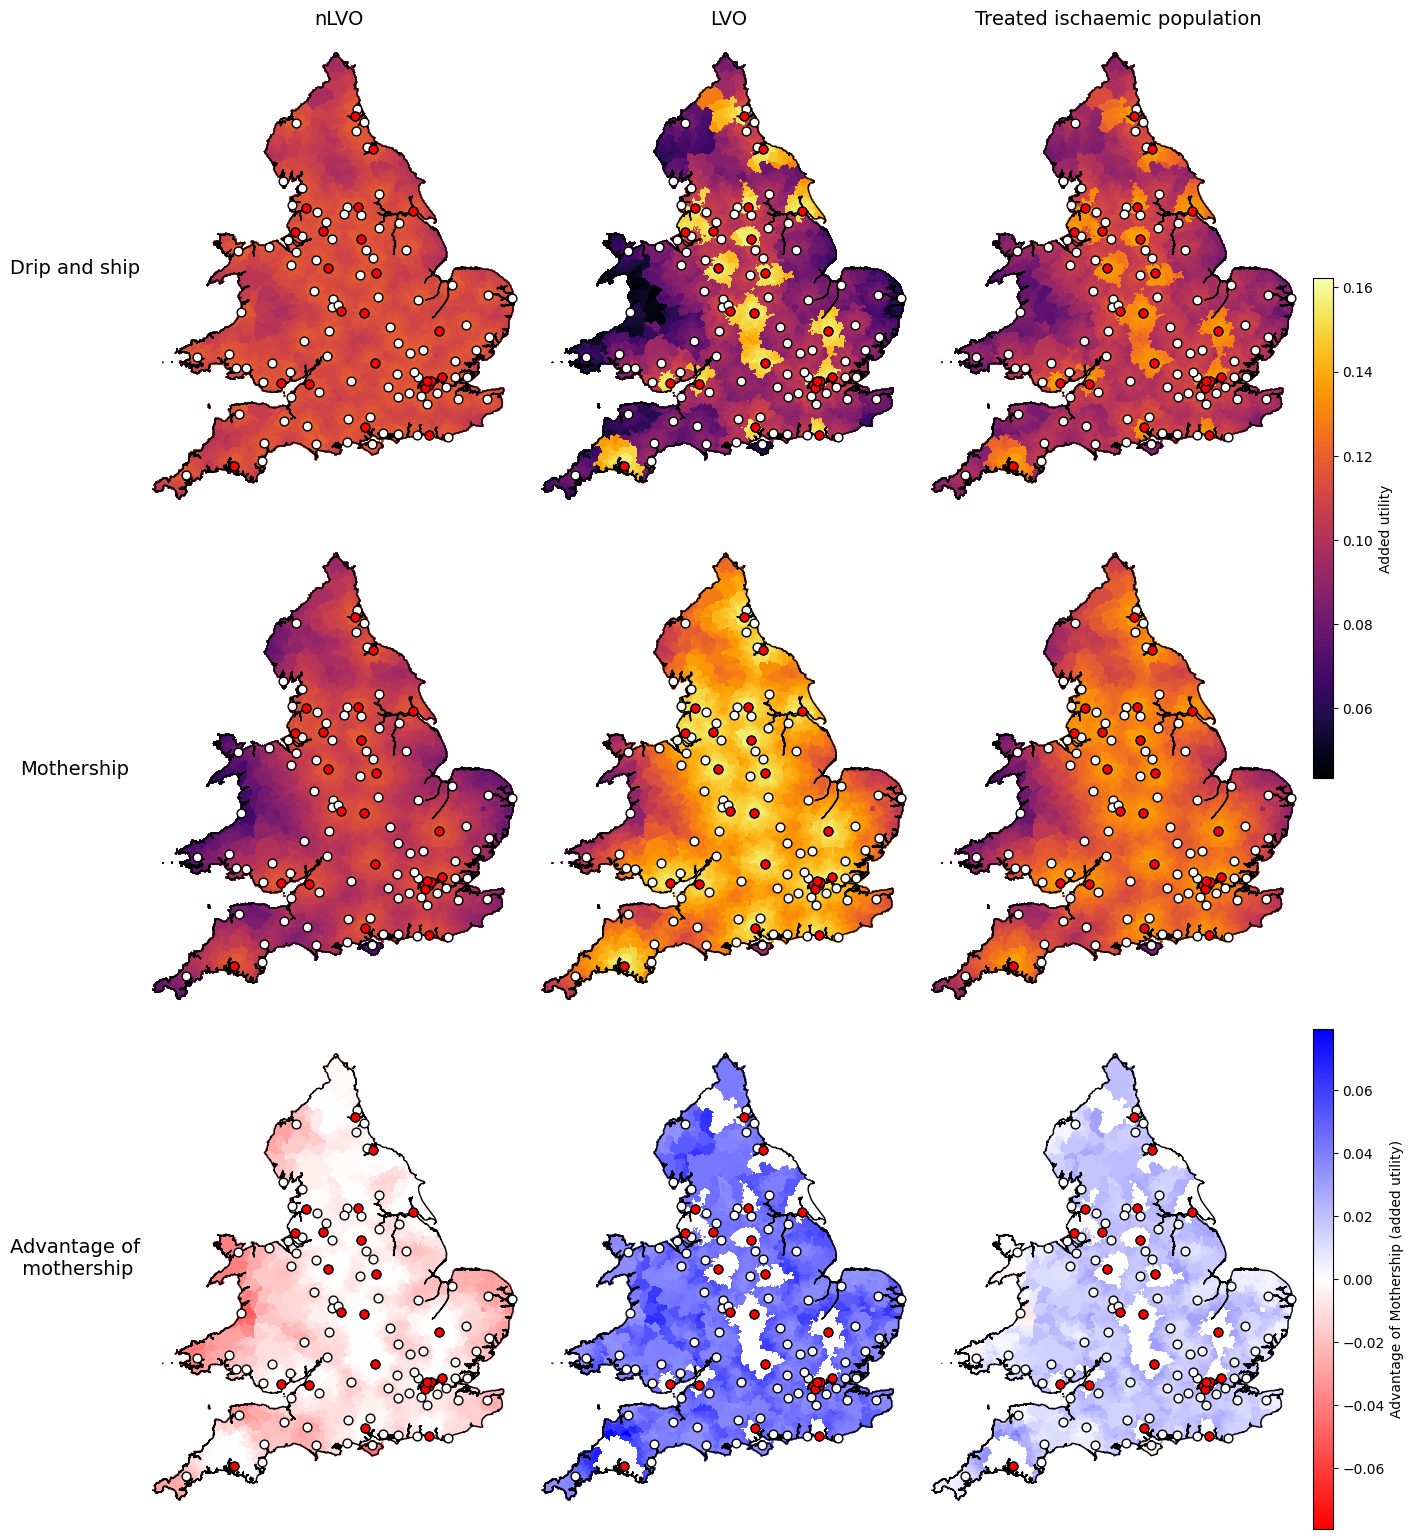

In [46]:
plot_nine(
    lsoa_data_gdf,
    axs_cols_added_utility,
    axs_params,
    params_added_utility,
    hospitals_gdf,
    outline,
    col_titles,
    row_titles,
    savename=os.path.join(dir_output, f'{data_field}_nine_in_one.jpg')
)

Settings for mRS shift:

In [47]:
data_field = 'mrs_shift'

vmin_scenarios, vmax_scenarios = find_vlims_scenarios(lsoa_data_gdf, data_field, cohorts)
vmin_diff, vmax_diff = find_vlims_diff(lsoa_data_gdf, data_field, cohorts)

params_mrs_shift = {
    'shared': {
        'vmin': vmin_scenarios,
        'vmax': vmax_scenarios,
        'cmap': 'inferno_r',
        'cbar_label': 'Mean mRS shift'
    },
    'diff': {
        'vmin': vmin_diff,
        'vmax': vmax_diff,
        'cmap': 'bwr',
        'cbar_label': 'Advantage of Mothership (mean mRS shift)'
    },
}

axs_cols_mrs_shift = [
    # First row:
    [f'drip_ship_nlvo_ivt_{data_field}',
     f'drip_ship_lvo_mix_{data_field}',
     f'drip_ship_weighted_treated_{data_field}'],
    # Second row:
    [f'mothership_nlvo_ivt_{data_field}',
     f'mothership_lvo_mix_{data_field}',
     f'mothership_weighted_treated_{data_field}'],
    # Third row:
    [f'nlvo_ivt_{data_field}_mothership_minus_dripship',
     f'lvo_mix_{data_field}_mothership_minus_dripship',
     f'weighted_treated_{data_field}_mothership_minus_dripship'],   
]

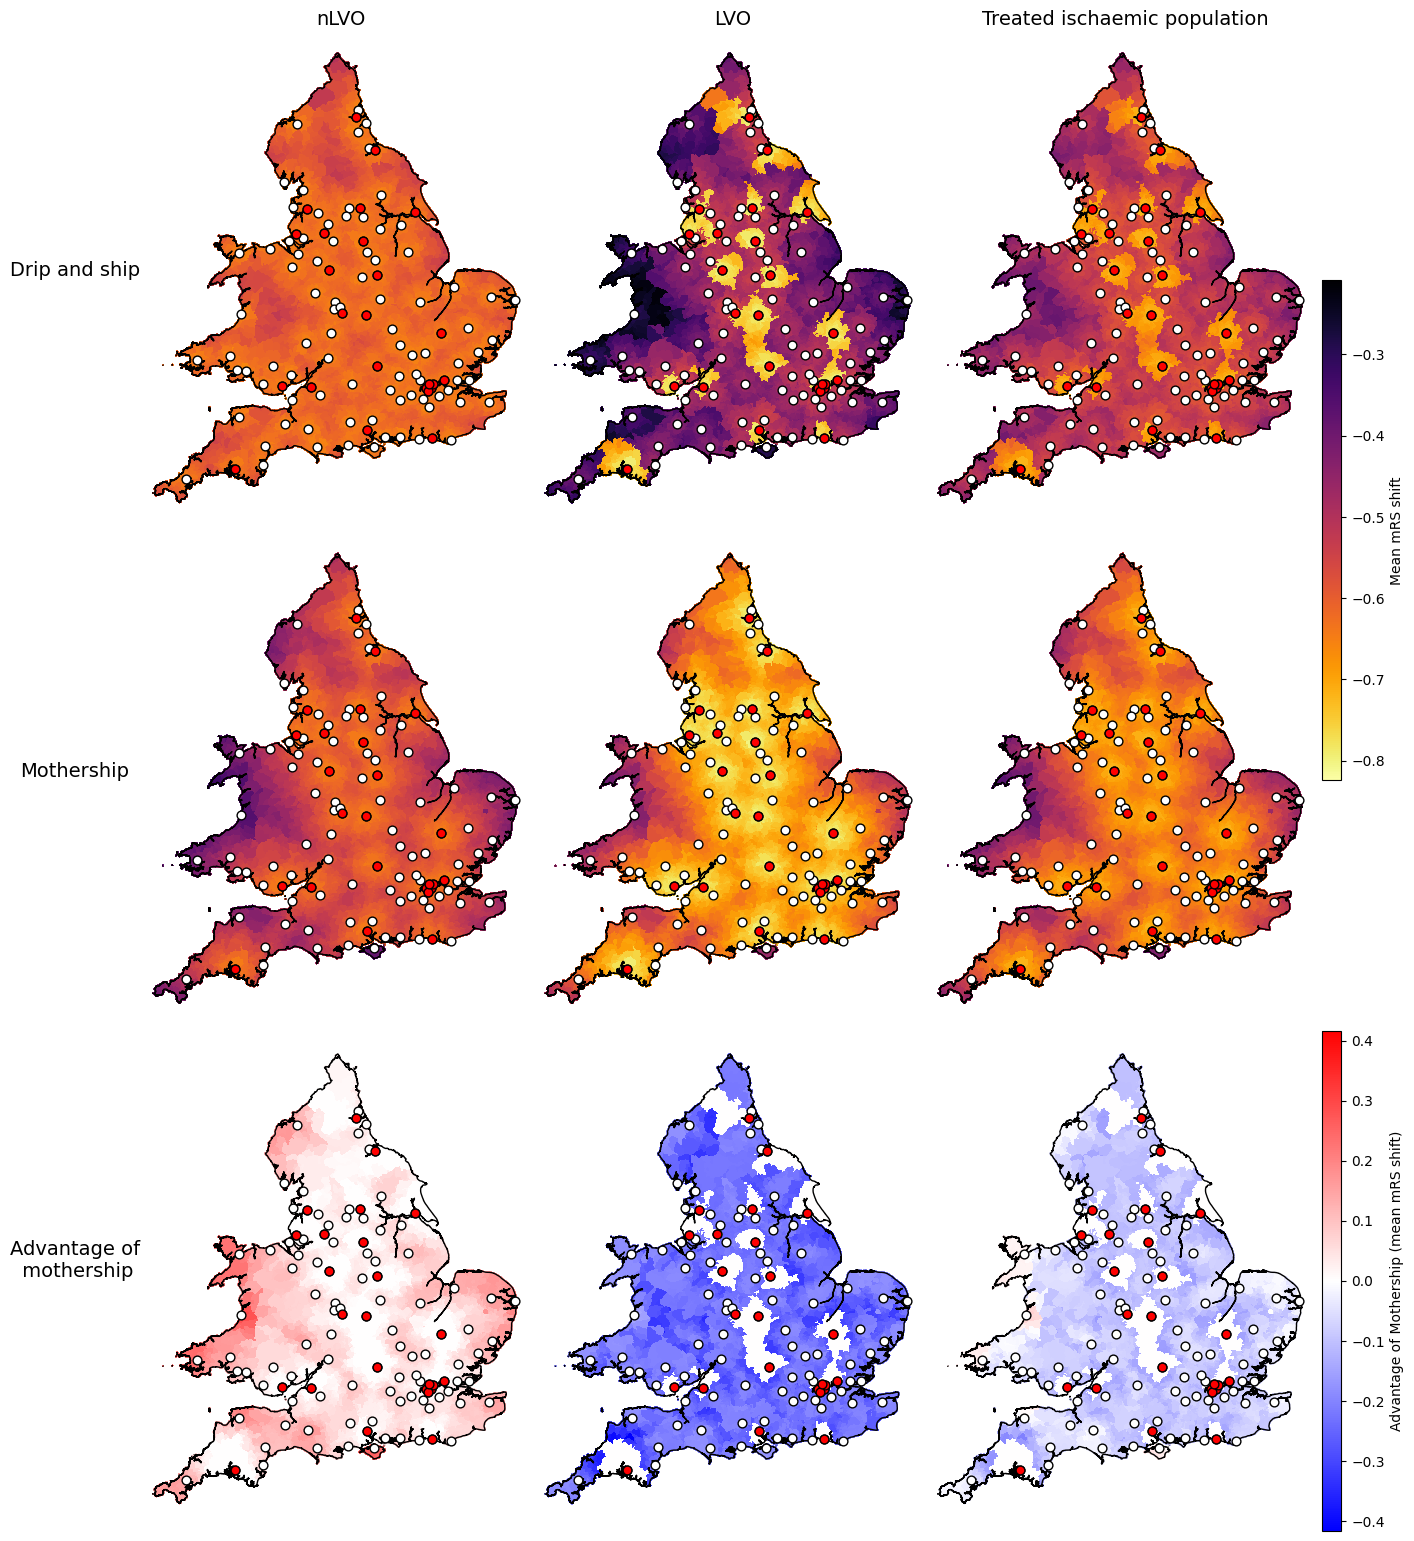

In [48]:
plot_nine(
    lsoa_data_gdf,
    axs_cols_mrs_shift,
    axs_params,
    params_mrs_shift,
    hospitals_gdf,
    outline,
    col_titles,
    row_titles,
    savename=os.path.join(dir_output, f'{data_field}_nine_in_one.jpg')
)

Settings for proportion with mRS less than or equal to 2:

In [49]:
data_field = 'added_mrs_less_equal_2'

vmin_scenarios, vmax_scenarios = find_vlims_scenarios(lsoa_data_gdf, data_field, cohorts)
vmin_diff, vmax_diff = find_vlims_diff(lsoa_data_gdf, data_field, cohorts)

params_added_mrs_less_equal_2 = {
    'shared': {
        'vmin': vmin_scenarios,
        'vmax': vmax_scenarios,
        'cmap': 'inferno',
        'cbar_label': r'Added mRS$\leq$2'
    },
    'diff': {
        'vmin': vmin_diff,
        'vmax': vmax_diff,
        'cmap': 'bwr_r',
        'cbar_label': r'Advantage of Mothership (added mRS$\leq$2)'
    },
}

axs_cols_added_mrs_less_equal_2 = [
    # First row:
    [f'drip_ship_nlvo_ivt_{data_field}',
     f'drip_ship_lvo_mix_{data_field}',
     f'drip_ship_weighted_treated_{data_field}'],
    # Second row:
    [f'mothership_nlvo_ivt_{data_field}',
     f'mothership_lvo_mix_{data_field}',
     f'mothership_weighted_treated_{data_field}'],
    # Third row:
    [f'nlvo_ivt_{data_field}_mothership_minus_dripship',
     f'lvo_mix_{data_field}_mothership_minus_dripship',
     f'weighted_treated_{data_field}_mothership_minus_dripship'],   
]

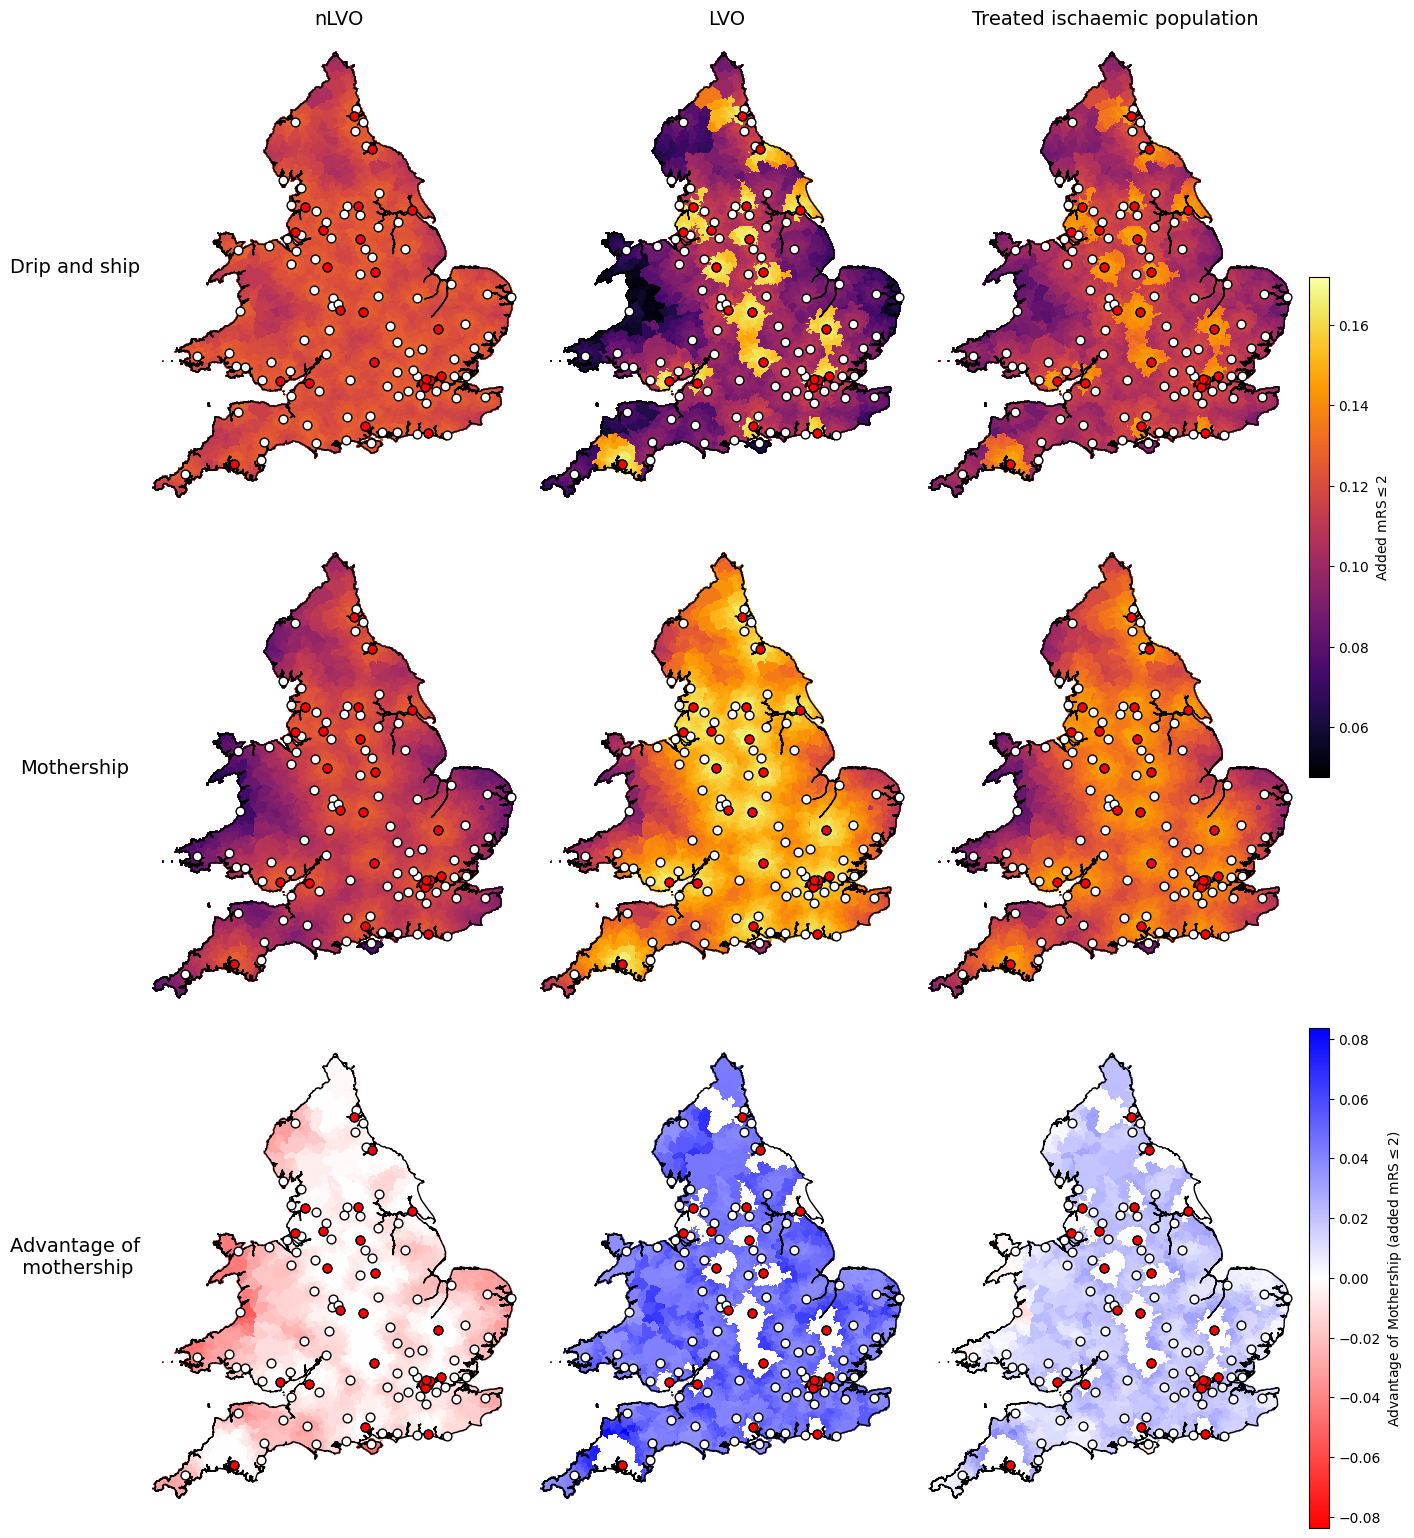

In [50]:
plot_nine(
    lsoa_data_gdf,
    axs_cols_added_mrs_less_equal_2,
    axs_params,
    params_added_mrs_less_equal_2,
    hospitals_gdf,
    outline,
    col_titles,
    row_titles,
    savename=os.path.join(dir_output, f'{data_field}_nine_in_one.jpg')
)